<a href="https://colab.research.google.com/github/moe-yamazaki/ai-picture/blob/main/ai_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 画像分類実践

(colab) ページ上部の ランタイム → ランタイムのタイプを変更 → ハードウェアアクセラレータを「GPU」に変更 → 保存  
深層学習では、簡単な計算を大量に行い学習を進めます。こういった計算にはGPUが適しています。

[参考資料](https://aiacademy.jp/texts/show/?id=164)


### パッケージの準備

In [85]:
# 必要なパッケージをインストール
# !から始まる行はshell command (Pythonではない)
!pip install icrawler

%matplotlib inline
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [86]:
# ダウンロードした画像を全て同じ大きさにリサイズし、メモリに格納
import numpy as np
import cv2
from pathlib import Path  # ディスク上のファイル一覧を取得するなど、パスの操作に用いるモジュール

name_20 = "20"
name_100 = "100"
name_200 = "200"
name_1000 = "1000"

img_size = 100
imgs_20 = list()
imgs_100 = list()
imgs_200 = list()
imgs_1000 = list()

for img_list, img_dir in ((imgs_20, name_20), (imgs_100, name_100), (imgs_200, name_200), (imgs_1000, name_1000)):
  # 画像パス一つずつを処理
  for impath in Path(img_dir).iterdir():
    # 画像読み込み: cv2.imread()
    img = cv2.imread(str(impath))
    if img is None: continue
    # 画像リサイズ
    img = cv2.resize(img, (img_size, img_size))
    img_list.append(img)

# listをndarrayに変換
imgs_20 = np.array(imgs_20)
imgs_100 = np.array(imgs_100)
imgs_200 = np.array(imgs_200)
imgs_1000 = np.array(imgs_1000)

# テンソルの情報を確認
#print('imgs_20.ndim =', imgs_cat.ndim)
#print('imgs_20.shape =', imgs_cat.shape)
#print('imgs_20.dtype =', imgs_cat.dtype)
#print('')
#print('imgs_dog.ndim =', imgs_dog.ndim)
#print('imgs_dog.shape =', imgs_dog.shape)
#print('imgs_dog.dtype =', imgs_dog.dtype)

In [87]:
# 画像の一覧可視化関数
import math
import PIL

def tile_show(imgs, n_col=10):
  h, w = imgs[0].shape[:2]
  assert all([img.shape[:2] == (h, w) for img in imgs])
  n_row = math.ceil(len(imgs) / n_col)
  tile = np.zeros((h*n_row, w*n_col, 3), imgs[0].dtype)
  for i, img in enumerate(imgs):
    row = i // n_col
    col = i % n_col
    y1 = row * h
    y2 = (row+1) * h
    x1 = col * w
    x2 = (col+1) * w
    tile[y1:y2, x1:x2] = img
  
  if not tile.dtype == np.uint8:
    tile -= tile.min()
    tile /= tile.max()
    tile *= 255
    tile = np.clip(tile.astype(np.uint8), 0, 255)
  return PIL.Image.fromarray(tile[..., ::-1])

15


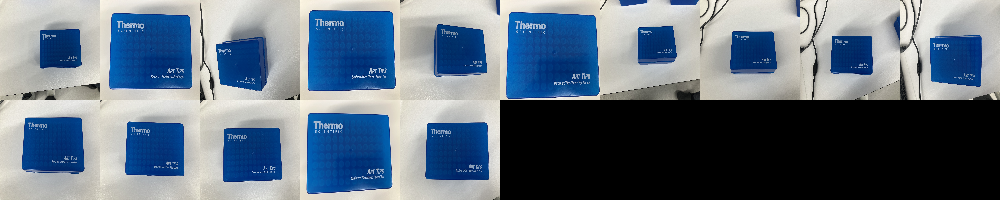

In [88]:
print(len(imgs_20))
tile_show(imgs_20)

9


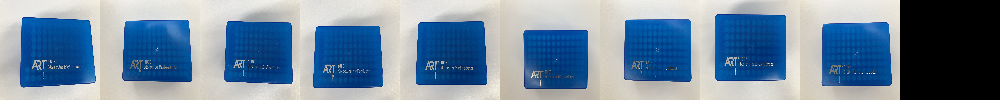

In [89]:
print(len(imgs_100))
tile_show(imgs_100)

16


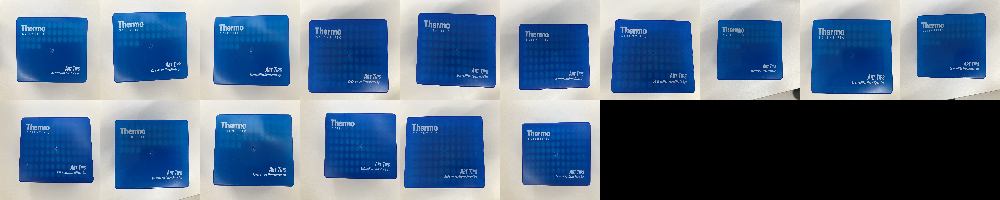

In [90]:
print(len(imgs_200))
tile_show(imgs_200)

15


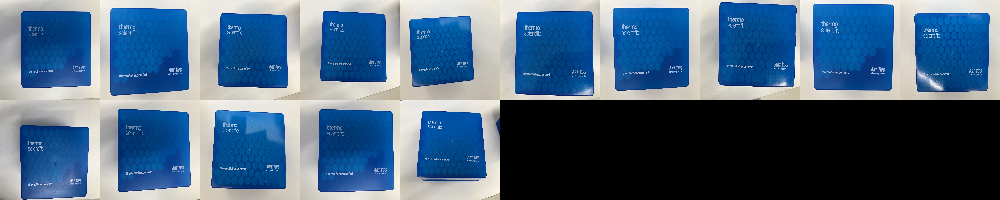

In [91]:
print(len(imgs_1000))
tile_show(imgs_1000)

(41,)
(41, 4)


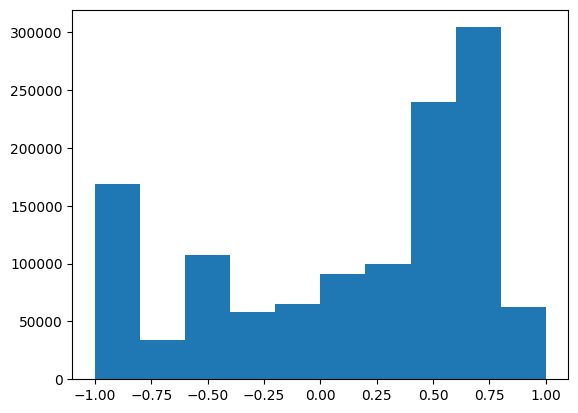

In [92]:
import tensorflow as tf

# 学習データとテストデータの作成
test_rate = 0.3
n_20_test = int(len(imgs_20) * test_rate)
n_100_test = int(len(imgs_100) * test_rate)
n_200_test = int(len(imgs_200) * test_rate)
n_1000_test = int(len(imgs_1000) * test_rate)

test_20, train_20 = imgs_20[:n_20_test], imgs_20[n_20_test:]
test_100, train_100 = imgs_100[:n_100_test], imgs_100[n_100_test:]
test_200, train_200 = imgs_100[:n_200_test], imgs_200[n_200_test:]
test_1000, train_1000 = imgs_100[:n_1000_test], imgs_1000[n_1000_test:]

# ndarrayの結合, dtypeをfloat32に変更, [-1,1]に正規化
train_X = np.concatenate([train_20, train_100, train_200, train_1000], axis=0)
train_X = train_X.astype(np.float32)
train_X = ((train_X / 255.) - 0.5) * 2
test_X = np.concatenate([test_20, test_100, test_200, test_1000], axis=0)
test_X = test_X.astype(np.float32)
test_X = ((test_X / 255.) - 0.5) * 2

# 正規化の確認。train_Xに含まれる全画素の輝度のヒストグラム
plt.hist(train_X.flatten())

# ラベルを作成。猫=0、犬=1として設定
train_y = np.array([0.] * len(train_20) + [1.] * len(train_100) + [2.] * len(train_200) + [3.] * len(train_1000)).astype(np.float32)
test_y = np.array([0.] * len(test_20) + [1.] * len(test_100) + [2.] * len(test_200) + [3.] * len(test_1000)).astype(np.float32)
print(train_y.shape)

# one-hot encoding
train_y = tf.keras.utils.to_categorical(train_y, 4)
test_y = tf.keras.utils.to_categorical(test_y, 4)
print(train_y.shape)

In [93]:
from tensorflow.keras.applications import VGG16

model = VGG16(
    include_top=True, 
    weights=None, 
    input_shape=(img_size, img_size, 3), 
    classes=4,
    )
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

In [94]:
print(train_X.shape)
print(train_y.shape)

(41, 100, 100, 3)
(41, 4)


In [95]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(train_X, train_y, epochs=30, batch_size=32)

Epoch 1/30
2/2 [==============================] - 11s 2s/step - loss: 1.3865 - accuracy: 0.1951
Epoch 2/30
2/2 [==============================] - 0s 82ms/step - loss: 1.3856 - accuracy: 0.2683
Epoch 3/30
2/2 [==============================] - 0s 69ms/step - loss: 1.3850 - accuracy: 0.2683
Epoch 4/30
2/2 [==============================] - 0s 84ms/step - loss: 1.3844 - accuracy: 0.2683
Epoch 5/30
2/2 [==============================] - 0s 60ms/step - loss: 1.3837 - accuracy: 0.2683
Epoch 6/30
2/2 [==============================] - 0s 66ms/step - loss: 1.3830 - accuracy: 0.3171
Epoch 7/30
2/2 [==============================] - 0s 70ms/step - loss: 1.3821 - accuracy: 0.3415
Epoch 8/30
2/2 [==============================] - 0s 77ms/step - loss: 1.3810 - accuracy: 0.3415
Epoch 9/30
2/2 [==============================] - 0s 91ms/step - loss: 1.3800 - accuracy: 0.3659
Epoch 10/30
2/2 [==============================] - 0s 70ms/step - loss: 1.3786 - accuracy: 0.3902
Epoch 11/30
2/2 [=============

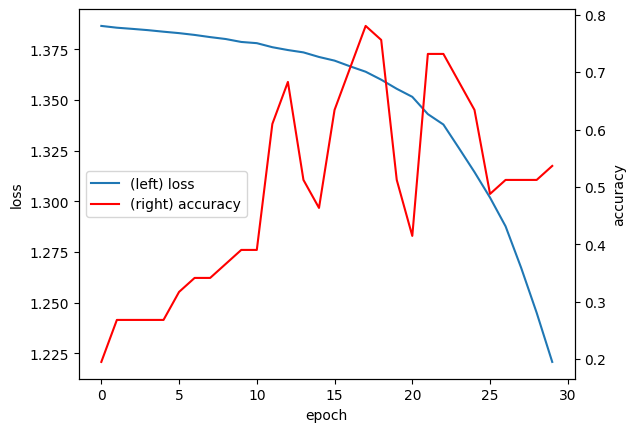

In [96]:
# 学習過程の可視化
fig, ax1 = plt.subplots()
ax1.plot(history.history['loss'], label='(left) loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax2 = ax1.twinx()
ax2.plot(history.history['accuracy'], label='(right) accuracy', c='r')
ax2.set_ylabel('accuracy')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='center left')
plt.show()

### 学習したモデルのテスト

テストデータから1枚、画像を取り出して学習したモデルに適用してみる。  
outputは`tf.Tensor`という型であり、`tf.Tensor.numpy()`メソッドによりnumpyの数値として情報を取り出すことができる。

In [97]:
# [-1,1]に正規化されている画像を表示する関数
def show_standardized_img(img):
  img -= img.min()
  img /= img.max()
  img *= 255
  img = np.clip(img, 0, 255).astype(np.uint8)
  return PIL.Image.fromarray(img[..., ::-1])

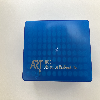

In [98]:
import random
ix = random.randint(0, len(test_X)-1)
show_standardized_img(test_X[ix])

In [99]:
output = model(test_X[ix][np.newaxis], training=False)
print(output)
print(output.numpy())

tf.Tensor([[1. 0. 0. 0.]], shape=(1, 4), dtype=float32)
[[1. 0. 0. 0.]]


In [100]:
vector = output.numpy()[0]
print('20ulである確率:', f'{vector[0]:.3f}')
print('100ulである確率:', f'{vector[1]:.3f}')
print('200ulである確率:', f'{vector[2]:.3f}')
print('1000ulである確率:', f'{vector[3]:.3f}')

20ulである確率: 1.000
100ulである確率: 0.000
200ulである確率: 0.000
1000ulである確率: 0.000


In [101]:
def sample_and_predict(model, X):
  ix = random.randint(0, len(X)-1)
  output = model(X[ix][np.newaxis], training=False)
  vector = output.numpy()[0]
  print('20ulである確率:', f'{vector[0]:.3f}')
  print('100ulである確率:', f'{vector[1]:.3f}')
  print('200ulである確率:', f'{vector[2]:.3f}')
  print('1000ulである確率:', f'{vector[3]:.3f}')
  return show_standardized_img(X[ix])

20ulである確率: 0.272
100ulである確率: 0.158
200ulである確率: 0.316
1000ulである確率: 0.255


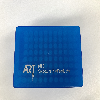

In [102]:
sample_and_predict(model, test_X)

In [103]:
# confusion matrixの算出
true = np.argmax(test_y, axis=1)
test_y_hat = model.predict(test_X)
pred = np.argmax(test_y_hat, axis=1)

confmat = tf.math.confusion_matrix(true, pred).numpy()
confmat

1/1 [==============================] - 1s 728ms/step


array([[2, 0, 2, 0],
       [1, 0, 1, 0],
       [1, 0, 3, 0],
       [2, 0, 2, 0]], dtype=int32)

In [104]:
'''
[[TP, FP], 
 [FN, TN]] = confmat

accuracy = (TP + TN) / (TP + FP + FN + TN)
sensitivity = TP / (TP + FN)
specificity = TN / (FP + TN)
precision = TP / (TP + FP)

print('正解率', accuracy)
print('感度', sensitivity)
print('特異度', specificity)
print('陽性的中率', precision)
'''

ValueError: ignored

### 学習モデルの実利用

学習モデルはデータセット外の実データに適用して初めて役立ちます。  
ここでは例として、画像URLを受け取ると猫か犬か判定してくれるwebサービスを想定します。

(実際のサービス例：[Google Lens](https://lens.google/intl/ja/#:~:text=%E6%A4%8D%E7%89%A9%E3%82%84%E5%8B%95%E7%89%A9,%E7%A2%BA%E8%AA%8D%E3%81%A7%E3%81%8D%E3%81%BE%E3%81%99%E3%80%82))

In [105]:
# urlから画像を読みこむcv2u.urlread()を使用するためパッケージをインストール
!pip install python-opencv-utils
import cv2u

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [106]:
#@title 犬猫画像判定サービス { run: "auto", vertical-output: true }

labels = {0: '20ul', 1: '100ul', 2:'200ul', 3:'1000ul'}

URL = '' #@param {type:"string"}
try:
  img = cv2u.urlread(URL)
except ValueError:
  img = None

if img is None:
  if URL:
    print('!!! 画像が見つかりません !!!')

else:
  X = cv2.resize(img, (img_size, img_size))
  X = ((X.astype(np.float32) / 255.) - 0.5) * 2
  X = X[np.newaxis]
  y = model.predict(X)
  label = labels[np.argmax(y[0])]
  score = np.max(y) * 100
  print(f'これは {score: .1f}% 「{label}」 です！')
  plt.imshow(img[..., ::-1])
  plt.axis("off")
  plt.show()

### より良い精度を目指して

- データセットの量を増やす  
今回のデモでは各クラスの画像の最大量は200枚としました。一般的には学習量を増やせば精度が向上する傾向にあります。

- 質の高いデータセットの準備  
画像データを可視化するとわかりますが、スクレイピングで得られた画像には全く関係ないものがある程度含まれます。これらを取り除き、質の高いデータセットを構築することが精度向上につながります。

- データの水増し (データ拡張、Data Augmentation)  
データセットの量を増やすのは人力が多く骨が折れます。水増しの手法では、1枚の画像を疑似的に増幅し、枚数が増えたように見せかけます。  
<img src="https://qph.fs.quoracdn.net/main-qimg-7565e09ecc4a93604b9c26c8c2a89bf9-pjlq" width="500"><a href="https://www.quora.com/What-is-data-augmentation-in-CNN">src</a>

- モデルの変更  
VGG16は2014年に開発されたモデルで古いため、よりよいモデルが多く開発されています。   
代表的なもの: ResNet (2015), EfficientNet (2019)